# Baseline Models

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import re
from sklearn.feature_extraction.text import TfidfVectorizer

## Sentiment Analysis

In [132]:
df = pd.read_csv("../data/TeleAntiFraud/distilbert_sentiment_analysis.csv")
df = df[['sentiment_neg', 'sentiment_pos', 'text_length', 'target']]
df.head()

,sentiment_neg,sentiment_pos,text_length,target
0,0.446601,0.553399,828,0
1,0.945283,0.054717,879,0
2,0.014362,0.985638,776,1
3,0.949376,0.050624,846,1
4,0.002714,0.997286,943,1


In [133]:
df['target'].value_counts()/len(df)*100

target
0    60.705459
1    39.294541
Name: count, dtype: float64

In [134]:
y = df['target']
X = df.drop('target', axis=1)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

In [136]:
ct = make_column_transformer(
    (StandardScaler(), ['sentiment_neg', 'sentiment_pos', 'text_length']),
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [137]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1081
           1       0.77      0.88      0.82       700

    accuracy                           0.85      1781
   macro avg       0.84      0.86      0.85      1781
weighted avg       0.86      0.85      0.85      1781



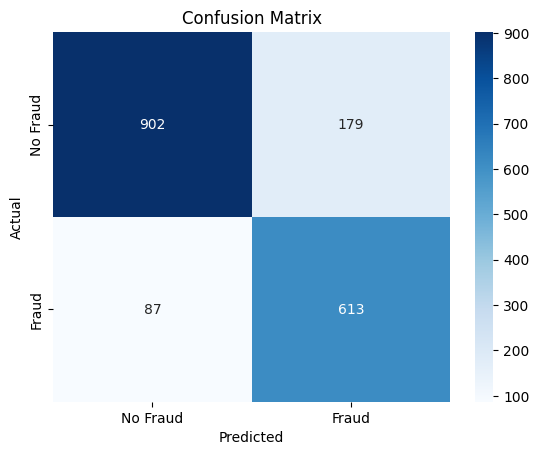

In [139]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [140]:
y_pred_proba = pipeline.predict_proba(X_test)

y_pred_proba[:, 1]

array([0.99, 0.82, 0.  , ..., 0.  , 0.72, 0.5 ])

PR-AUC (Average Precision): 0.811


Text(0.5, 1.0, 'Precision-Recall Curve')

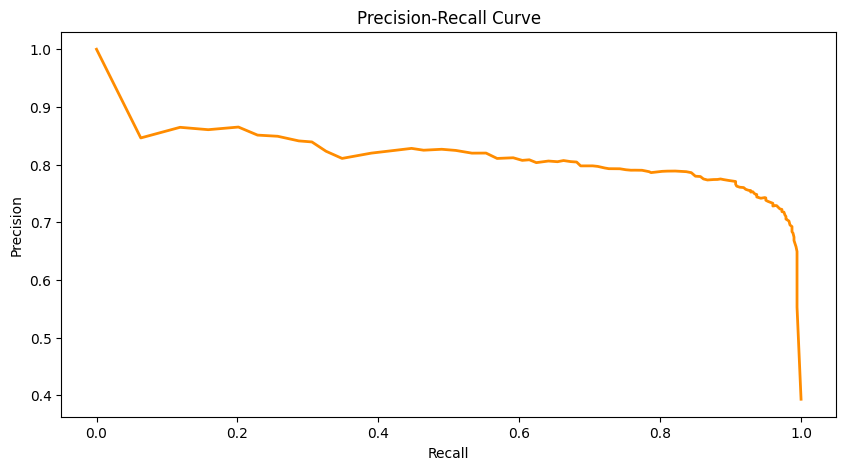

In [141]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
pr_auc = average_precision_score(y_test, y_pred_proba[:, 1])

print(f"PR-AUC (Average Precision): {pr_auc:.3f}")
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')


In [142]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.912


1. Optimize for recall

In [143]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

target_recall = 0.90
idx = np.argmin(np.abs(recall - target_recall))
threshold_for_recall = thresholds[idx]
precision_at_recall = precision[idx]

print(f"To achieve {target_recall*100:.0f}% recall:")
print(f"  Threshold: {threshold_for_recall:.3f}")
print(f"  Precision: {precision_at_recall:.3f}")
print(f"  False alarm rate: {(1-precision_at_recall)*100:.1f}%")

To achieve 90% recall:
  Threshold: 0.470
  Precision: 0.772
  False alarm rate: 22.8%


In [144]:
y_pred_custom = (y_pred_proba[:, 1] >= threshold_for_recall).astype(int)
y_pred_custom

array([1, 1, 0, ..., 0, 1, 1])

In [145]:
print(f"Using threshold: {threshold_for_recall}")
print(classification_report(y_test, y_pred_custom))

Using threshold: 0.47
              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1081
           1       0.77      0.90      0.83       700

    accuracy                           0.86      1781
   macro avg       0.85      0.86      0.85      1781
weighted avg       0.87      0.86      0.86      1781



In [146]:
mixed_test = pd.DataFrame({
    'sentiment_neg': [0.05, 0.08, 0.65, 0.12, 0.45],
    'sentiment_pos': [0.85, 0.92, 0.25, 0.78, 0.40],
    'text_length': [650, 720, 180, 580, 250]
})

mixed_test

,sentiment_neg,sentiment_pos,text_length
0,0.05,0.85,650
1,0.08,0.92,720
2,0.65,0.25,180
3,0.12,0.78,580
4,0.45,0.40,250


In [147]:
def fraud_detection_system(new_data):
    """Production fraud detection function"""
    fraud_probs = pipeline.predict_proba(new_data)[:, 1]
    predictions = (fraud_probs >= threshold_for_recall).astype(int)
    
    return({
        'fraud_probability': fraud_probs,
        'is_fraud': predictions,
        'action': ['BLOCK' if pred == 1 else 'ALLOW' for pred in predictions]
    })

In [148]:
fraud_detection_system(mixed_test)

{'fraud_probability': array([0.71, 0.85, 0.01, 0.52, 0.06]),
 'is_fraud': array([1, 1, 0, 1, 0]),
 'action': ['BLOCK', 'BLOCK', 'ALLOW', 'BLOCK', 'ALLOW']}

## Logistic regression

In [70]:
df = pd.read_csv("../data/TeleAntiFraud/cleaned_data.csv")

In [71]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text


In [72]:
df['cleaned_text'] = df['perp_text_en'].apply(preprocess_text)
label_mapping = {'NEG': 1, 'POS': 0}
df['label'] = df['label'].map(label_mapping)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], 
    df['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

In [74]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,        # Maximum number of features
    min_df=2,                 # Minimum document frequency
    max_df=0.7,               # Maximum document frequency (ignore very common words)
    ngram_range=(1, 2),       # Use unigrams and bigrams
    stop_words='english',     # Remove common English stop words
    sublinear_tf=True         # Use log scaling for term frequency
)

In [75]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [76]:
log_reg = LogisticRegression(
    C=0.1,                    # Stronger regularization
    penalty='l2',             # L2 regularization
    max_iter=1000,            # Maximum iterations
    random_state=42,
    class_weight='balanced'   # Handle class imbalance
)
log_reg.fit(X_train_tfidf, y_train)
y_pred = log_reg.predict(X_test_tfidf)
y_pred_proba = log_reg.predict_proba(X_test_tfidf)[:, 1]

In [77]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


ROC-AUC Score: 0.9999


In [78]:
print(confusion_matrix(y_test, y_pred))

[[1078    3]
 [   3  697]]


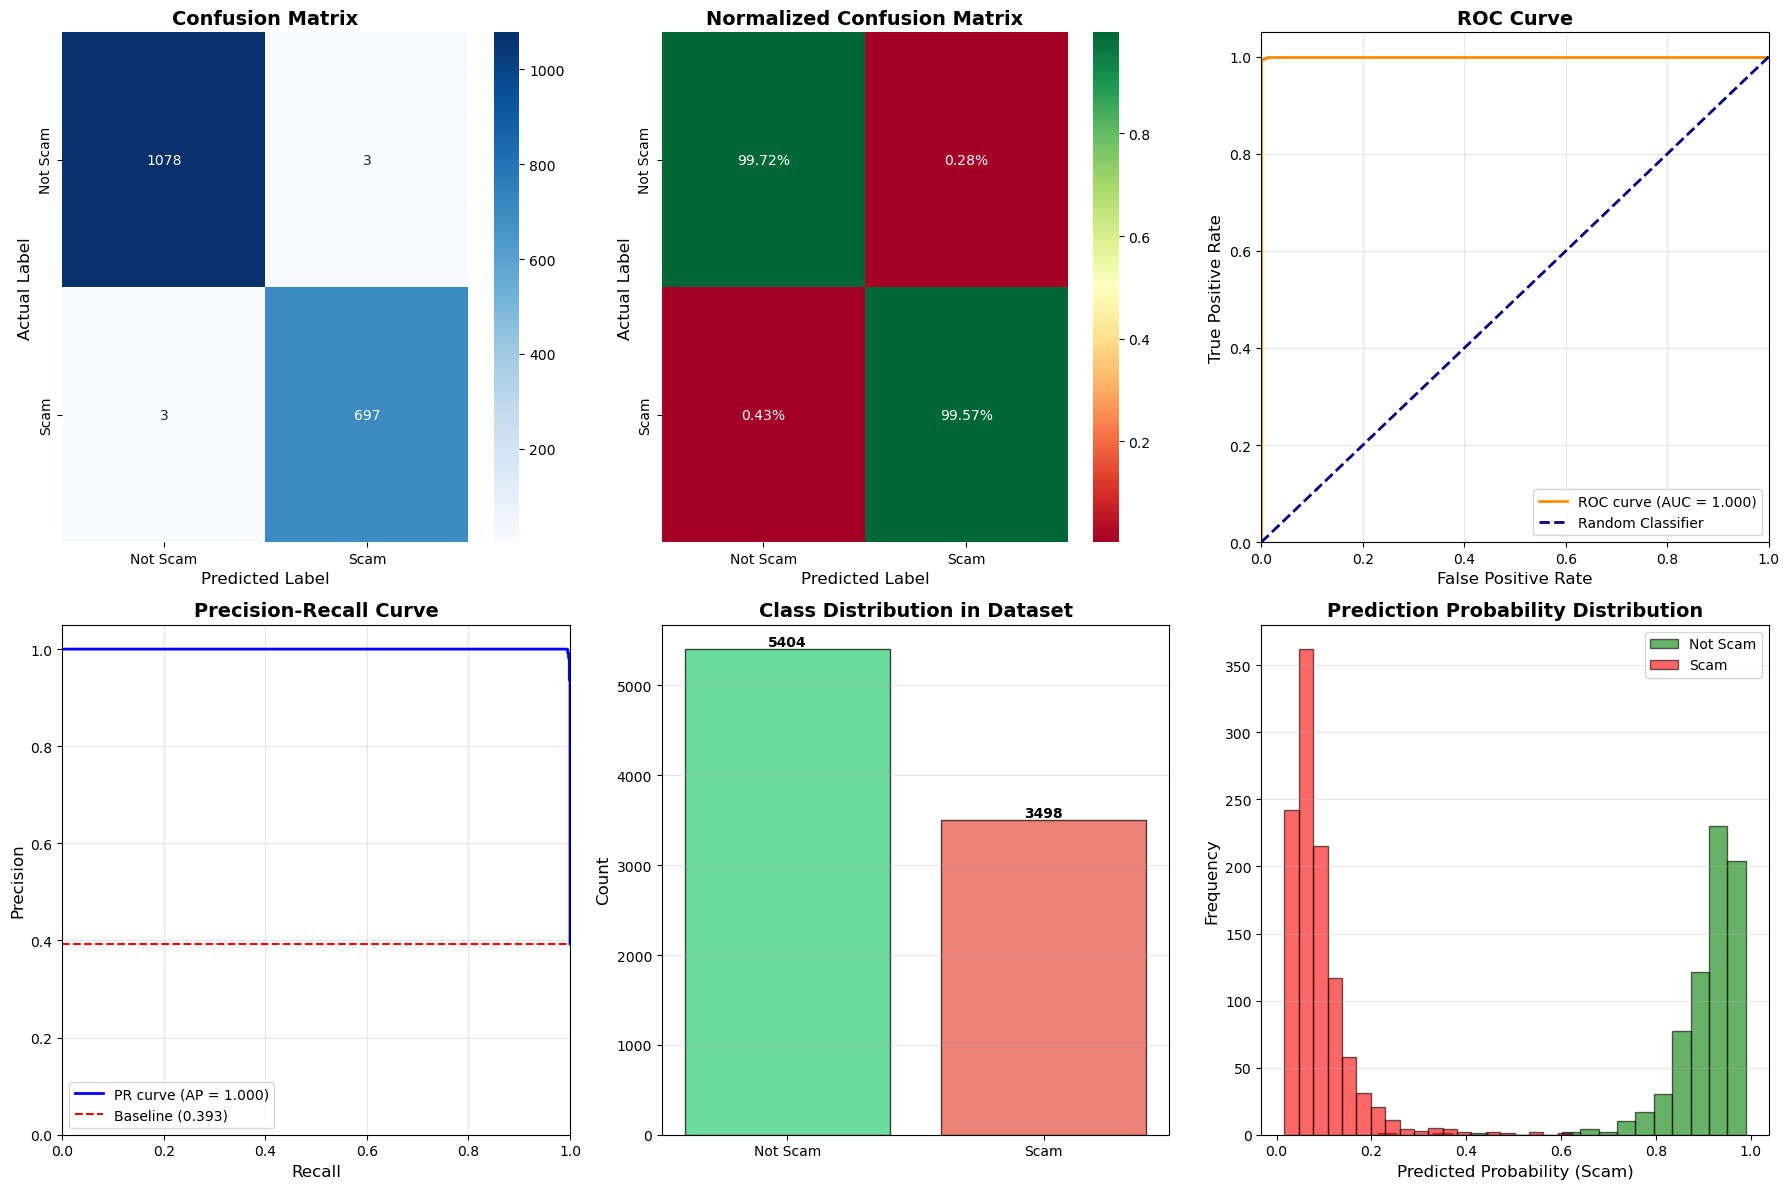

In [79]:
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Scam', 'Scam'],
            yticklabels=['Not Scam', 'Scam'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix
plt.subplot(2, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', cbar=True,
            xticklabels=['Not Scam', 'Scam'],
            yticklabels=['Not Scam', 'Scam'])
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 3. ROC Curve
plt.subplot(2, 3, 3)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
plt.subplot(2, 3, 4)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'PR curve (AP = {avg_precision:.3f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', 
            label=f'Baseline ({y_test.mean():.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# 5. Class Distribution
plt.subplot(2, 3, 5)
class_counts = df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Not Scam', 'Scam'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# 6. Prediction Probability Distribution
plt.subplot(2, 3, 6)
scam_probs = y_pred_proba[y_test == 0]
not_scam_probs = y_pred_proba[y_test == 1]
plt.hist(not_scam_probs, bins=20, alpha=0.6, label='Not Scam', color='green', edgecolor='black')
plt.hist(scam_probs, bins=20, alpha=0.6, label='Scam', color='red', edgecolor='black')
plt.xlabel('Predicted Probability (Scam)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [81]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = log_reg.coef_[0]
top_scam_indices = coefficients.argsort()[-15:][::-1]
print("\nTop 15 words most associated with SCAM:")
for i, idx in enumerate(top_scam_indices, 1):
    print(f"  {i:2d}. {feature_names[idx]:20s}: {coefficients[idx]:7.4f}")

top_legit_indices = coefficients.argsort()[:15]
print("\nTop 15 words most associated with LEGITIMATE messages:")
for i, idx in enumerate(top_legit_indices, 1):
    print(f"  {i:2d}. {feature_names[idx]:20s}: {coefficients[idx]:7.4f}")


Top 15 words most associated with SCAM:
   1. link                :  2.3542
   2. loan                :  2.1674
   3. bank                :  2.0216
   4. download            :  1.7538
   5. app                 :  1.7387
   6. information         :  1.6260
   7. click               :  1.4817
   8. wechat              :  1.4729
   9. click link          :  1.3791
  10. send                :  1.2972
  11. investment          :  1.2694
  12. need                :  1.2505
  13. add                 :  1.2383
  14. low                 :  1.2309
  15. financial           :  1.1277

Top 15 words most associated with LEGITIMATE messages:
   1. okay                : -1.4199
   2. like                : -1.1394
   3. clock               : -1.0925
   4. points              : -1.0835
   5. come                : -1.0356
   6. ll                  : -1.0243
   7. want                : -0.9089
   8. tomorrow            : -0.8854
   9. saw                 : -0.8233
  10. thank               : -0.8233
  1